In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools
from scipy import linalg

from scipy.stats import multivariate_normal
from utils import confidence_ellipse
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse

In [2]:
X = np.array([[-0.4,-1],
[1.4,0.2],
[1.8,0.3],
[1.3,0.4],
[0.1,-0.1],
[-0.9,-0.2],
[0.7,0.1],
[-0.6,-1.2],
[1.2,0.8],
[0.6,1.4],
[4.8,6.8],
[5.2,5.6],
[5.6,1.8],
[3.3,4.6],
[3.4,3.4],
[6.2,6.0],
[3.5,4.5],
[5.1,4.4],
[4.5,5.5],
[4.6,3.9]])


In [3]:
p1 = 0.5
p2 = 0.5
mu1 = [0.6, 1.4]
mu2 = [5.6, 1.8]
sigma1 = np.identity(2)
sigma2 = np.identity(2)

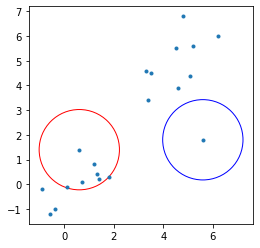

In [4]:
# draw current fitting
fig, axs = plt.subplots()
axs.plot(X[:,0],X[:,1],'.')
ellipse = confidence_ellipse(mu1,sigma1,n_std=1.3,ax=axs,edgecolor='red')
axs.add_patch(ellipse)

ellipse = confidence_ellipse(mu2,sigma2,n_std=1.3,ax=axs,edgecolor='blue')
axs.add_patch(ellipse)
axs.set_aspect('equal')

[[0.005 0.000 1.000 0.000]
 [0.056 0.000 1.000 0.000]
 [0.042 0.000 0.999 0.001]
 [0.076 0.000 1.000 0.000]
 [0.046 0.000 1.000 0.000]
 [0.014 0.000 1.000 0.000]
 [0.068 0.000 1.000 0.000]
 [0.003 0.000 1.000 0.000]
 [0.111 0.000 1.000 0.000]
 [0.159 0.000 1.000 0.000]
 [0.000 0.000 0.000 1.000]
 [0.000 0.000 0.000 1.000]
 [0.000 0.159 0.000 1.000]
 [0.000 0.000 0.100 0.900]
 [0.000 0.004 0.098 0.902]
 [0.000 0.000 0.000 1.000]
 [0.000 0.000 0.041 0.959]
 [0.000 0.005 0.000 1.000]
 [0.000 0.000 0.000 1.000]
 [0.000 0.011 0.000 1.000]]


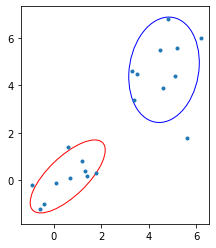

In [5]:
normal_1 = multivariate_normal(mean=mu1, cov=sigma1)
normal_2 = multivariate_normal(mean=mu2, cov=sigma2)

# expectation (compute cluster memberships)
afmat = np.zeros([20,4])
for i in range(20):
    f1 = normal_1.pdf(X[i,:])
    f2 = normal_2.pdf(X[i,:])
    a1 = (p1*f1)/(p1*f1+p2*f2)
    a2 = (p2*f2)/(p1*f1+p2*f2)
    afmat[i,0] = f1
    afmat[i,1] = f2
    afmat[i,2] = a1
    afmat[i,3] = a2

np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(afmat)
# log-likelihood
loglikehd = np.log(np.prod(p1*afmat[:,0] + p2*afmat[:,1]))

# maximization (update parameters)
p1 = np.sum(afmat[:,2]) / 20
p2 = np.sum(afmat[:,3]) / 20

mu1 = [np.sum((afmat[:,2]/np.sum(afmat[:,2]))*X[:,0]), np.sum((afmat[:,2]/np.sum(afmat[:,2]))*X[:,1])]
mu2 = [np.sum((afmat[:,3]/np.sum(afmat[:,3]))*X[:,0]), np.sum((afmat[:,3]/np.sum(afmat[:,3]))*X[:,1])]

sigma1 = sigma2 = np.zeros([2,2])

for i in range(20):
  sigma1 = sigma1 + afmat[i,2]*(X[i,:]-(mu1))[np.newaxis].T.dot((X[i,:]-(mu1))[np.newaxis])
  sigma2 = sigma2 + afmat[i,3]*(X[i,:]-(mu2))[np.newaxis].T.dot((X[i,:]-(mu2))[np.newaxis])

sigma1 = sigma1 / np.sum(afmat[:,2])
sigma2 = sigma2 / np.sum(afmat[:,3])

# draw current fitting
fig, axs = plt.subplots()
axs.plot(X[:,0],X[:,1],'.')
ellipse = confidence_ellipse(mu1,sigma1,n_std=1.3,ax=axs,edgecolor='red')
axs.add_patch(ellipse)

ellipse = confidence_ellipse(mu2,sigma2,n_std=1.3,ax=axs,edgecolor='blue')
axs.add_patch(ellipse)
axs.set_aspect('equal')

np.set_printoptions(edgeitems=3, infstr='inf',
linewidth=75, nanstr='nan', precision=8,
suppress=False, threshold=1000, formatter=None)

In [30]:
cars = pd.read_csv('./cars.csv')
mean_cars = np.asarray(np.mean(cars))
sd_cars = np.asarray(np.std(cars))
cars_stdz = (np.array(cars)-mean_cars)/sd_cars
X = cars_stdz

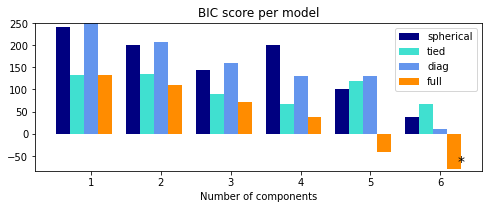

In [31]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F69100A1D0>,
      dtype=object)

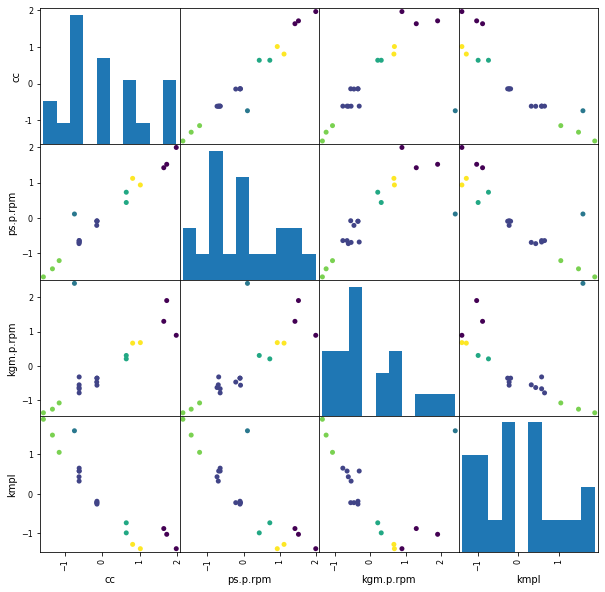

In [53]:
pd.plotting.scatter_matrix(pd.DataFrame(X,columns=list(cars.columns)),c=clf.predict(X),alpha=1, figsize = (10, 10),s=100)